<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:54] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


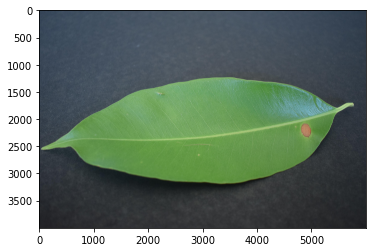

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

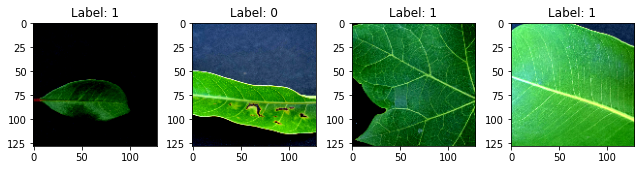

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:10:00] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:10:02] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2427292165899437 samples/sec                   batch loss = 0.718248188495636 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.261405736904992 samples/sec                   batch loss = 0.8552218079566956 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2635643700071322 samples/sec                   batch loss = 1.0645259618759155 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2564028579146258 samples/sec                   batch loss = 0.4457230567932129 | accuracy = 0.5


Epoch[1] Batch[25] Speed: 1.2636132864398273 samples/sec                   batch loss = 0.8894123435020447 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2684666811579137 samples/sec                   batch loss = 0.9533647298812866 | accuracy = 0.48333333333333334


Epoch[1] Batch[35] Speed: 1.2686304109864988 samples/sec                   batch loss = 0.5640758872032166 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.2685735275848242 samples/sec                   batch loss = 0.5766893625259399 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.265468239848891 samples/sec                   batch loss = 0.746001660823822 | accuracy = 0.55


Epoch[1] Batch[50] Speed: 1.2641418062972696 samples/sec                   batch loss = 0.6258710026741028 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.2668516013116733 samples/sec                   batch loss = 0.7063953876495361 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2623521869855325 samples/sec                   batch loss = 0.6273474097251892 | accuracy = 0.5666666666666667


Epoch[1] Batch[65] Speed: 1.2612274636581424 samples/sec                   batch loss = 0.537872314453125 | accuracy = 0.5769230769230769


Epoch[1] Batch[70] Speed: 1.2674486112751084 samples/sec                   batch loss = 0.7534205913543701 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.2635441002995729 samples/sec                   batch loss = 0.9317762851715088 | accuracy = 0.5933333333333334


Epoch[1] Batch[80] Speed: 1.263210362212268 samples/sec                   batch loss = 1.4835002422332764 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2602291173251667 samples/sec                   batch loss = 0.4110873341560364 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2661260513118202 samples/sec                   batch loss = 0.3345758020877838 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2618964381237194 samples/sec                   batch loss = 0.3474866449832916 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.2646956503909712 samples/sec                   batch loss = 0.5679419636726379 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2645911719150256 samples/sec                   batch loss = 0.9972134232521057 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2623484826995326 samples/sec                   batch loss = 0.5610003471374512 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2641670484411545 samples/sec                   batch loss = 0.5326486825942993 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.261112750612583 samples/sec                   batch loss = 0.5928710103034973 | accuracy = 0.6270833333333333


Epoch[1] Batch[125] Speed: 1.262682430689208 samples/sec                   batch loss = 0.45549747347831726 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2591275439929086 samples/sec                   batch loss = 0.5274490714073181 | accuracy = 0.625


Epoch[1] Batch[135] Speed: 1.265115167960219 samples/sec                   batch loss = 0.5849218964576721 | accuracy = 0.6222222222222222


Epoch[1] Batch[140] Speed: 1.2655256087807354 samples/sec                   batch loss = 1.140662670135498 | accuracy = 0.6321428571428571


Epoch[1] Batch[145] Speed: 1.2648909265204864 samples/sec                   batch loss = 1.018445611000061 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2667663737469164 samples/sec                   batch loss = 0.8529937267303467 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.2634865302637917 samples/sec                   batch loss = 0.8532533049583435 | accuracy = 0.6274193548387097


Epoch[1] Batch[160] Speed: 1.264089896377156 samples/sec                   batch loss = 0.7245877385139465 | accuracy = 0.63125


Epoch[1] Batch[165] Speed: 1.2655024123965593 samples/sec                   batch loss = 0.3423212766647339 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2673901104504515 samples/sec                   batch loss = 0.39355775713920593 | accuracy = 0.6367647058823529


Epoch[1] Batch[175] Speed: 1.2694010935760598 samples/sec                   batch loss = 0.5658766627311707 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2649319345398424 samples/sec                   batch loss = 0.3917810320854187 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.265703953416176 samples/sec                   batch loss = 0.2205735296010971 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.2623864764084547 samples/sec                   batch loss = 0.3436921536922455 | accuracy = 0.6473684210526316


Epoch[1] Batch[195] Speed: 1.2707310854980374 samples/sec                   batch loss = 0.44181960821151733 | accuracy = 0.6474358974358975


Epoch[1] Batch[200] Speed: 1.2649198225923217 samples/sec                   batch loss = 1.0133299827575684 | accuracy = 0.64375


Epoch[1] Batch[205] Speed: 1.2660822905916136 samples/sec                   batch loss = 0.9559321999549866 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.2658886522771555 samples/sec                   batch loss = 0.37019214034080505 | accuracy = 0.65


Epoch[1] Batch[215] Speed: 1.2637007554162292 samples/sec                   batch loss = 0.4614938199520111 | accuracy = 0.6523255813953488


Epoch[1] Batch[220] Speed: 1.264911716300323 samples/sec                   batch loss = 1.4231098890304565 | accuracy = 0.6545454545454545


Epoch[1] Batch[225] Speed: 1.2719009857124683 samples/sec                   batch loss = 0.35151615738868713 | accuracy = 0.6533333333333333


Epoch[1] Batch[230] Speed: 1.2694194385662472 samples/sec                   batch loss = 0.5296669602394104 | accuracy = 0.6543478260869565


Epoch[1] Batch[235] Speed: 1.2684007983027523 samples/sec                   batch loss = 1.1850714683532715 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.267068500268485 samples/sec                   batch loss = 0.18743793666362762 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.267632095695962 samples/sec                   batch loss = 0.2724609673023224 | accuracy = 0.6530612244897959


Epoch[1] Batch[250] Speed: 1.2649319345398424 samples/sec                   batch loss = 0.8283953666687012 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2609965419811664 samples/sec                   batch loss = 0.3113669157028198 | accuracy = 0.6558823529411765


Epoch[1] Batch[260] Speed: 1.2597687512741507 samples/sec                   batch loss = 0.27815717458724976 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.265385679717261 samples/sec                   batch loss = 0.48938965797424316 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.2687734573922742 samples/sec                   batch loss = 0.42366284132003784 | accuracy = 0.6648148148148149


Epoch[1] Batch[275] Speed: 1.2648644157742854 samples/sec                   batch loss = 1.0120031833648682 | accuracy = 0.6636363636363637


Epoch[1] Batch[280] Speed: 1.2641089453939394 samples/sec                   batch loss = 0.5266466736793518 | accuracy = 0.6660714285714285


Epoch[1] Batch[285] Speed: 1.2592091004737904 samples/sec                   batch loss = 0.3737833797931671 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.2631945739575956 samples/sec                   batch loss = 0.5094020962715149 | accuracy = 0.6689655172413793


Epoch[1] Batch[295] Speed: 1.2580853457852958 samples/sec                   batch loss = 0.39219292998313904 | accuracy = 0.6703389830508475


Epoch[1] Batch[300] Speed: 1.2620343623679242 samples/sec                   batch loss = 0.7922648787498474 | accuracy = 0.6708333333333333


Epoch[1] Batch[305] Speed: 1.2652015092331674 samples/sec                   batch loss = 0.49215877056121826 | accuracy = 0.6737704918032786


Epoch[1] Batch[310] Speed: 1.2597997787400468 samples/sec                   batch loss = 0.6118069887161255 | accuracy = 0.6725806451612903


Epoch[1] Batch[315] Speed: 1.2615375777256403 samples/sec                   batch loss = 0.41296815872192383 | accuracy = 0.6738095238095239


Epoch[1] Batch[320] Speed: 1.2655101444301335 samples/sec                   batch loss = 0.3913787603378296 | accuracy = 0.675


Epoch[1] Batch[325] Speed: 1.2694093535583748 samples/sec                   batch loss = 0.6617575883865356 | accuracy = 0.6753846153846154


Epoch[1] Batch[330] Speed: 1.2634546548972678 samples/sec                   batch loss = 0.6363716721534729 | accuracy = 0.6757575757575758


Epoch[1] Batch[335] Speed: 1.2639547600878707 samples/sec                   batch loss = 1.2131012678146362 | accuracy = 0.6746268656716418


Epoch[1] Batch[340] Speed: 1.2689016605176238 samples/sec                   batch loss = 0.4562455415725708 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2675897631563537 samples/sec                   batch loss = 0.35728466510772705 | accuracy = 0.6768115942028986


Epoch[1] Batch[350] Speed: 1.2649214438631895 samples/sec                   batch loss = 0.6033562421798706 | accuracy = 0.6764285714285714


Epoch[1] Batch[355] Speed: 1.2596539251075294 samples/sec                   batch loss = 1.3452544212341309 | accuracy = 0.676056338028169


Epoch[1] Batch[360] Speed: 1.2647962367651184 samples/sec                   batch loss = 0.3924662172794342 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.267327307065744 samples/sec                   batch loss = 0.4543823003768921 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2648374293575113 samples/sec                   batch loss = 0.5725707411766052 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.2657655455464518 samples/sec                   batch loss = 0.23890240490436554 | accuracy = 0.674


Epoch[1] Batch[380] Speed: 1.2660751248230464 samples/sec                   batch loss = 0.8050653338432312 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2664125772164312 samples/sec                   batch loss = 0.4129355847835541 | accuracy = 0.6733766233766234


Epoch[1] Batch[390] Speed: 1.2639602830625851 samples/sec                   batch loss = 0.43091094493865967 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.2641296142265457 samples/sec                   batch loss = 0.5636193752288818 | accuracy = 0.6734177215189874


Epoch[1] Batch[400] Speed: 1.2608954218819695 samples/sec                   batch loss = 0.1465183049440384 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.262210584752509 samples/sec                   batch loss = 0.5185121893882751 | accuracy = 0.6746913580246914


Epoch[1] Batch[410] Speed: 1.2643656868969857 samples/sec                   batch loss = 0.05413663387298584 | accuracy = 0.675609756097561


Epoch[1] Batch[415] Speed: 1.2604914824194242 samples/sec                   batch loss = 0.35472697019577026 | accuracy = 0.6765060240963855


Epoch[1] Batch[420] Speed: 1.2652650563057195 samples/sec                   batch loss = 0.4214492440223694 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2638478333842573 samples/sec                   batch loss = 1.0960328578948975 | accuracy = 0.6764705882352942


Epoch[1] Batch[430] Speed: 1.2601231039623852 samples/sec                   batch loss = 0.5176492929458618 | accuracy = 0.6761627906976744


Epoch[1] Batch[435] Speed: 1.2670776868656857 samples/sec                   batch loss = 0.18722261488437653 | accuracy = 0.6764367816091954


Epoch[1] Batch[440] Speed: 1.2660006056380786 samples/sec                   batch loss = 0.4256858229637146 | accuracy = 0.678409090909091


Epoch[1] Batch[445] Speed: 1.2597405630112586 samples/sec                   batch loss = 0.4200323820114136 | accuracy = 0.6769662921348315


Epoch[1] Batch[450] Speed: 1.2677905325974093 samples/sec                   batch loss = 0.717602550983429 | accuracy = 0.6761111111111111


Epoch[1] Batch[455] Speed: 1.2656228901213284 samples/sec                   batch loss = 0.9469120502471924 | accuracy = 0.676923076923077


Epoch[1] Batch[460] Speed: 1.2668852746210513 samples/sec                   batch loss = 0.30695319175720215 | accuracy = 0.6782608695652174


Epoch[1] Batch[465] Speed: 1.2700266590886433 samples/sec                   batch loss = 0.3742661774158478 | accuracy = 0.6790322580645162


Epoch[1] Batch[470] Speed: 1.261531601610186 samples/sec                   batch loss = 0.7682924270629883 | accuracy = 0.6792553191489362


Epoch[1] Batch[475] Speed: 1.2665292126105037 samples/sec                   batch loss = 1.0706840753555298 | accuracy = 0.6778947368421052


Epoch[1] Batch[480] Speed: 1.2696704628141642 samples/sec                   batch loss = 0.45514965057373047 | accuracy = 0.678125


Epoch[1] Batch[485] Speed: 1.269889866080836 samples/sec                   batch loss = 1.542185664176941 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2646813503098118 samples/sec                   batch loss = 0.37837499380111694 | accuracy = 0.6780612244897959


Epoch[1] Batch[495] Speed: 1.2683376070602033 samples/sec                   batch loss = 0.46664783358573914 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2650291246264982 samples/sec                   batch loss = 0.9590224623680115 | accuracy = 0.678


Epoch[1] Batch[505] Speed: 1.261978733408488 samples/sec                   batch loss = 0.8104038834571838 | accuracy = 0.6797029702970298


Epoch[1] Batch[510] Speed: 1.267450622037749 samples/sec                   batch loss = 0.46317994594573975 | accuracy = 0.6799019607843138


Epoch[1] Batch[515] Speed: 1.2677363109174515 samples/sec                   batch loss = 1.0976428985595703 | accuracy = 0.6796116504854369


Epoch[1] Batch[520] Speed: 1.2695485408211695 samples/sec                   batch loss = 0.664512574672699 | accuracy = 0.6793269230769231


Epoch[1] Batch[525] Speed: 1.265909761421676 samples/sec                   batch loss = 0.41791534423828125 | accuracy = 0.6804761904761905


Epoch[1] Batch[530] Speed: 1.266150799433715 samples/sec                   batch loss = 0.47479432821273804 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.266375965781342 samples/sec                   batch loss = 0.3321584463119507 | accuracy = 0.6789719626168225


Epoch[1] Batch[540] Speed: 1.262757985390672 samples/sec                   batch loss = 0.8470931649208069 | accuracy = 0.6782407407407407


Epoch[1] Batch[545] Speed: 1.2667000935686485 samples/sec                   batch loss = 0.6633431315422058 | accuracy = 0.6779816513761467


Epoch[1] Batch[550] Speed: 1.2660876410850375 samples/sec                   batch loss = 0.7459073066711426 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2663671717049345 samples/sec                   batch loss = 0.5772533416748047 | accuracy = 0.6774774774774774


Epoch[1] Batch[560] Speed: 1.2671729099639053 samples/sec                   batch loss = 0.2395382672548294 | accuracy = 0.6776785714285715


Epoch[1] Batch[565] Speed: 1.2645674378793108 samples/sec                   batch loss = 0.8745933175086975 | accuracy = 0.6765486725663716


Epoch[1] Batch[570] Speed: 1.2642846043812999 samples/sec                   batch loss = 0.192384734749794 | accuracy = 0.6776315789473685


Epoch[1] Batch[575] Speed: 1.2707435977373072 samples/sec                   batch loss = 0.487946480512619 | accuracy = 0.6782608695652174


Epoch[1] Batch[580] Speed: 1.2684159497944492 samples/sec                   batch loss = 0.575072169303894 | accuracy = 0.6775862068965517


Epoch[1] Batch[585] Speed: 1.2669540617448838 samples/sec                   batch loss = 0.4895492196083069 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2662562047793027 samples/sec                   batch loss = 0.27629539370536804 | accuracy = 0.6800847457627118


Epoch[1] Batch[595] Speed: 1.26414647363659 samples/sec                   batch loss = 0.8705253005027771 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.2649023703514382 samples/sec                   batch loss = 0.6685132384300232 | accuracy = 0.6791666666666667


Epoch[1] Batch[605] Speed: 1.2597661026588405 samples/sec                   batch loss = 0.48906415700912476 | accuracy = 0.6789256198347108


Epoch[1] Batch[610] Speed: 1.2687652056833476 samples/sec                   batch loss = 0.4507755637168884 | accuracy = 0.6790983606557377


Epoch[1] Batch[615] Speed: 1.2682273491063598 samples/sec                   batch loss = 0.8669079542160034 | accuracy = 0.6784552845528455


Epoch[1] Batch[620] Speed: 1.2645225458143274 samples/sec                   batch loss = 0.41460052132606506 | accuracy = 0.6790322580645162


Epoch[1] Batch[625] Speed: 1.2711708941754194 samples/sec                   batch loss = 0.4546818435192108 | accuracy = 0.6796


Epoch[1] Batch[630] Speed: 1.2705688336968965 samples/sec                   batch loss = 0.22183026373386383 | accuracy = 0.6817460317460318


Epoch[1] Batch[635] Speed: 1.2640015164507938 samples/sec                   batch loss = 0.6654806733131409 | accuracy = 0.6811023622047244


Epoch[1] Batch[640] Speed: 1.2663278866160141 samples/sec                   batch loss = 0.31389957666397095 | accuracy = 0.6828125


Epoch[1] Batch[645] Speed: 1.2590720765018464 samples/sec                   batch loss = 0.35600411891937256 | accuracy = 0.6841085271317829


Epoch[1] Batch[650] Speed: 1.271180525616568 samples/sec                   batch loss = 0.457041472196579 | accuracy = 0.6838461538461539


Epoch[1] Batch[655] Speed: 1.2659390861526971 samples/sec                   batch loss = 0.6270735263824463 | accuracy = 0.683587786259542


Epoch[1] Batch[660] Speed: 1.2619727531126554 samples/sec                   batch loss = 0.6427972316741943 | accuracy = 0.6840909090909091


Epoch[1] Batch[665] Speed: 1.2654461909443733 samples/sec                   batch loss = 1.2374086380004883 | accuracy = 0.6842105263157895


Epoch[1] Batch[670] Speed: 1.2694737082645178 samples/sec                   batch loss = 0.8008986711502075 | accuracy = 0.6854477611940298


Epoch[1] Batch[675] Speed: 1.2638373606817477 samples/sec                   batch loss = 1.0068600177764893 | accuracy = 0.6855555555555556


Epoch[1] Batch[680] Speed: 1.2643081372482747 samples/sec                   batch loss = 0.3909224569797516 | accuracy = 0.6863970588235294


Epoch[1] Batch[685] Speed: 1.2705282291122835 samples/sec                   batch loss = 0.33450576663017273 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.2635551391206983 samples/sec                   batch loss = 0.8445395827293396 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2675827718551138 samples/sec                   batch loss = 1.0777703523635864 | accuracy = 0.6881294964028777


Epoch[1] Batch[700] Speed: 1.266079710905585 samples/sec                   batch loss = 0.5902653336524963 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.27135025555501 samples/sec                   batch loss = 0.6595770120620728 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2668460530404253 samples/sec                   batch loss = 1.0365674495697021 | accuracy = 0.6894366197183098


Epoch[1] Batch[715] Speed: 1.2608235957125786 samples/sec                   batch loss = 0.6320827603340149 | accuracy = 0.6895104895104895


Epoch[1] Batch[720] Speed: 1.2695406632944857 samples/sec                   batch loss = 0.2638547122478485 | accuracy = 0.6899305555555556


Epoch[1] Batch[725] Speed: 1.2704997497199968 samples/sec                   batch loss = 0.2771373689174652 | accuracy = 0.6903448275862069


Epoch[1] Batch[730] Speed: 1.2691880999998715 samples/sec                   batch loss = 0.680058479309082 | accuracy = 0.690068493150685


Epoch[1] Batch[735] Speed: 1.2621975752757209 samples/sec                   batch loss = 0.44846537709236145 | accuracy = 0.6921768707482994


Epoch[1] Batch[740] Speed: 1.2609965419811664 samples/sec                   batch loss = 0.5219398140907288 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.2667343326792486 samples/sec                   batch loss = 0.5238061547279358 | accuracy = 0.6922818791946309


Epoch[1] Batch[750] Speed: 1.2633508570148013 samples/sec                   batch loss = 0.4511586129665375 | accuracy = 0.693


Epoch[1] Batch[755] Speed: 1.2582456515074154 samples/sec                   batch loss = 0.8395295739173889 | accuracy = 0.6933774834437086


Epoch[1] Batch[760] Speed: 1.2625684029787712 samples/sec                   batch loss = 0.7282343506813049 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.2696007078857936 samples/sec                   batch loss = 0.6844502091407776 | accuracy = 0.6937908496732026


Epoch[1] Batch[770] Speed: 1.2617114790201147 samples/sec                   batch loss = 0.4468643069267273 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.2688569400181073 samples/sec                   batch loss = 0.6004958152770996 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.262594627528468 samples/sec                   batch loss = 0.5195952653884888 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.267540634138403 samples/sec                   batch loss = 0.5456553101539612 | accuracy = 0.6955414012738853


[Epoch 1] training: accuracy=0.6960659898477157
[Epoch 1] time cost: 649.5803244113922
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2693042869127917 samples/sec                   batch loss = 0.5853523015975952 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2713011236135554 samples/sec                   batch loss = 0.3430081009864807 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.263712463281856 samples/sec                   batch loss = 0.6162593364715576 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2650983780979506 samples/sec                   batch loss = 0.3486580550670624 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.267114913086643 samples/sec                   batch loss = 0.2438298612833023 | accuracy = 0.68


Epoch[2] Batch[30] Speed: 1.26985882019017 samples/sec                   batch loss = 0.6090936064720154 | accuracy = 0.7


Epoch[2] Batch[35] Speed: 1.2728697270227667 samples/sec                   batch loss = 0.2688499987125397 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2735866895849095 samples/sec                   batch loss = 0.3517640233039856 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.267479635180285 samples/sec                   batch loss = 0.7355449795722961 | accuracy = 0.7055555555555556


Epoch[2] Batch[50] Speed: 1.2677622716024606 samples/sec                   batch loss = 0.13259749114513397 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2676994313296128 samples/sec                   batch loss = 0.646436870098114 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2718342635638464 samples/sec                   batch loss = 0.27308136224746704 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2667104224908459 samples/sec                   batch loss = 0.2424994260072708 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2713576738447652 samples/sec                   batch loss = 1.1842668056488037 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2706114616811859 samples/sec                   batch loss = 1.0797077417373657 | accuracy = 0.75


Epoch[2] Batch[80] Speed: 1.272373833590176 samples/sec                   batch loss = 0.5853326916694641 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2699091864261272 samples/sec                   batch loss = 0.6521944999694824 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.2753850583992188 samples/sec                   batch loss = 0.570746123790741 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2726859783929119 samples/sec                   batch loss = 0.5330256223678589 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2737197353108267 samples/sec                   batch loss = 0.7161716818809509 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2726950535379207 samples/sec                   batch loss = 0.4133400619029999 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2645567626195895 samples/sec                   batch loss = 0.38625025749206543 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2678186990459932 samples/sec                   batch loss = 0.659284234046936 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2690255700405808 samples/sec                   batch loss = 0.44124510884284973 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.270452126561967 samples/sec                   batch loss = 0.39811083674430847 | accuracy = 0.724


Epoch[2] Batch[130] Speed: 1.2658183572157244 samples/sec                   batch loss = 0.7863213419914246 | accuracy = 0.7192307692307692


Epoch[2] Batch[135] Speed: 1.2746799190542706 samples/sec                   batch loss = 0.23575790226459503 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2717412306357965 samples/sec                   batch loss = 0.4430994987487793 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2722360521439446 samples/sec                   batch loss = 0.5108069181442261 | accuracy = 0.7293103448275862


Epoch[2] Batch[150] Speed: 1.2703782455769985 samples/sec                   batch loss = 0.16883288323879242 | accuracy = 0.725


Epoch[2] Batch[155] Speed: 1.2756227353083829 samples/sec                   batch loss = 0.6280583739280701 | accuracy = 0.7258064516129032


Epoch[2] Batch[160] Speed: 1.2750518199255119 samples/sec                   batch loss = 0.4727945625782013 | accuracy = 0.728125


Epoch[2] Batch[165] Speed: 1.2664222322818095 samples/sec                   batch loss = 0.6413529515266418 | accuracy = 0.7287878787878788


Epoch[2] Batch[170] Speed: 1.2823453049965956 samples/sec                   batch loss = 0.35159164667129517 | accuracy = 0.7264705882352941


Epoch[2] Batch[175] Speed: 1.269028449713022 samples/sec                   batch loss = 1.0668240785598755 | accuracy = 0.73


Epoch[2] Batch[180] Speed: 1.2624182978994931 samples/sec                   batch loss = 0.2018895447254181 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2674256315837464 samples/sec                   batch loss = 1.0266226530075073 | accuracy = 0.7364864864864865


Epoch[2] Batch[190] Speed: 1.274964807259903 samples/sec                   batch loss = 0.31817346811294556 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2704074891060382 samples/sec                   batch loss = 0.24421550333499908 | accuracy = 0.7384615384615385


Epoch[2] Batch[200] Speed: 1.2690710703932413 samples/sec                   batch loss = 0.3374637961387634 | accuracy = 0.73625


Epoch[2] Batch[205] Speed: 1.2719506461906755 samples/sec                   batch loss = 0.16736534237861633 | accuracy = 0.7402439024390244


Epoch[2] Batch[210] Speed: 1.2769550148780813 samples/sec                   batch loss = 0.2966931462287903 | accuracy = 0.7392857142857143


Epoch[2] Batch[215] Speed: 1.2808091048727681 samples/sec                   batch loss = 0.8250763416290283 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2726358743370747 samples/sec                   batch loss = 0.2584468126296997 | accuracy = 0.7363636363636363


Epoch[2] Batch[225] Speed: 1.271251128536254 samples/sec                   batch loss = 0.35368672013282776 | accuracy = 0.7377777777777778


Epoch[2] Batch[230] Speed: 1.2709073382837253 samples/sec                   batch loss = 0.21688280999660492 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.2691001577712415 samples/sec                   batch loss = 0.8637758493423462 | accuracy = 0.7361702127659574


Epoch[2] Batch[240] Speed: 1.276977952643353 samples/sec                   batch loss = 0.4055424630641937 | accuracy = 0.7364583333333333


Epoch[2] Batch[245] Speed: 1.2772016390479903 samples/sec                   batch loss = 0.22815203666687012 | accuracy = 0.7377551020408163


Epoch[2] Batch[250] Speed: 1.2755289533817922 samples/sec                   batch loss = 0.2725803554058075 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2741899690482985 samples/sec                   batch loss = 0.4617244005203247 | accuracy = 0.7401960784313726


Epoch[2] Batch[260] Speed: 1.2677666783187562 samples/sec                   batch loss = 0.12323717772960663 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2691947249626818 samples/sec                   batch loss = 0.14034715294837952 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2674988822551987 samples/sec                   batch loss = 0.3021002411842346 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2668134340146466 samples/sec                   batch loss = 0.769378125667572 | accuracy = 0.7472727272727273


Epoch[2] Batch[280] Speed: 1.2655843194786436 samples/sec                   batch loss = 0.30058106780052185 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.2690661746290335 samples/sec                   batch loss = 0.3082110583782196 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2706083823629983 samples/sec                   batch loss = 0.24365417659282684 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2665998735152824 samples/sec                   batch loss = 0.3095752000808716 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.2707051955699713 samples/sec                   batch loss = 0.3529459238052368 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.2668717859498275 samples/sec                   batch loss = 1.0544029474258423 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.2775960273115856 samples/sec                   batch loss = 0.31171295046806335 | accuracy = 0.7451612903225806


Epoch[2] Batch[315] Speed: 1.2736470208301653 samples/sec                   batch loss = 0.46705812215805054 | accuracy = 0.7444444444444445


Epoch[2] Batch[320] Speed: 1.2662001074561902 samples/sec                   batch loss = 0.20972630381584167 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.2684989058326532 samples/sec                   batch loss = 0.2512594759464264 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.2755409784216856 samples/sec                   batch loss = 1.1703343391418457 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.272983691344164 samples/sec                   batch loss = 0.598168134689331 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2695751522134948 samples/sec                   batch loss = 0.3418842852115631 | accuracy = 0.7433823529411765


Epoch[2] Batch[345] Speed: 1.2730935220353814 samples/sec                   batch loss = 0.5866978168487549 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.2662067012619338 samples/sec                   batch loss = 0.222036212682724 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.2694836982367819 samples/sec                   batch loss = 0.3777596652507782 | accuracy = 0.745774647887324


Epoch[2] Batch[360] Speed: 1.2700478103217818 samples/sec                   batch loss = 0.665644109249115 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2670157756046303 samples/sec                   batch loss = 0.40948301553726196 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.270786237449377 samples/sec                   batch loss = 0.4235132932662964 | accuracy = 0.7466216216216216


Epoch[2] Batch[375] Speed: 1.2702749420463921 samples/sec                   batch loss = 0.2623976469039917 | accuracy = 0.7493333333333333


Epoch[2] Batch[380] Speed: 1.2710250919865766 samples/sec                   batch loss = 0.7146588563919067 | accuracy = 0.7486842105263158


Epoch[2] Batch[385] Speed: 1.2692673160422066 samples/sec                   batch loss = 0.22931690514087677 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.269005124742044 samples/sec                   batch loss = 0.4035317301750183 | accuracy = 0.7493589743589744


Epoch[2] Batch[395] Speed: 1.2758482757068292 samples/sec                   batch loss = 1.253416657447815 | accuracy = 0.7493670886075949


Epoch[2] Batch[400] Speed: 1.2737047469393747 samples/sec                   batch loss = 0.8504455089569092 | accuracy = 0.74875


Epoch[2] Batch[405] Speed: 1.2707481214536893 samples/sec                   batch loss = 0.43572890758514404 | accuracy = 0.7493827160493827


Epoch[2] Batch[410] Speed: 1.2755586284876312 samples/sec                   batch loss = 0.23266936838626862 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.2705194734875147 samples/sec                   batch loss = 0.31011131405830383 | accuracy = 0.7506024096385542


Epoch[2] Batch[420] Speed: 1.270573644838608 samples/sec                   batch loss = 0.5653232336044312 | accuracy = 0.75


Epoch[2] Batch[425] Speed: 1.2687254838423534 samples/sec                   batch loss = 1.0972063541412354 | accuracy = 0.7511764705882353


Epoch[2] Batch[430] Speed: 1.2705300572249911 samples/sec                   batch loss = 0.338967502117157 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.2675442731943185 samples/sec                   batch loss = 0.6274154782295227 | accuracy = 0.7522988505747127


Epoch[2] Batch[440] Speed: 1.269731961119169 samples/sec                   batch loss = 0.2751624584197998 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.2693874552358853 samples/sec                   batch loss = 0.42352503538131714 | accuracy = 0.753370786516854


Epoch[2] Batch[450] Speed: 1.2696795910923024 samples/sec                   batch loss = 0.5001171827316284 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2710053525174363 samples/sec                   batch loss = 0.7507586479187012 | accuracy = 0.7527472527472527


Epoch[2] Batch[460] Speed: 1.2699088980584428 samples/sec                   batch loss = 0.328744113445282 | accuracy = 0.7527173913043478


Epoch[2] Batch[465] Speed: 1.2690884458613325 samples/sec                   batch loss = 0.2852531671524048 | accuracy = 0.7537634408602151


Epoch[2] Batch[470] Speed: 1.2671117549932713 samples/sec                   batch loss = 0.2631387710571289 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.2697412824759189 samples/sec                   batch loss = 1.1637550592422485 | accuracy = 0.7526315789473684


Epoch[2] Batch[480] Speed: 1.2738518416325746 samples/sec                   batch loss = 0.41590985655784607 | accuracy = 0.7536458333333333


Epoch[2] Batch[485] Speed: 1.267007259691231 samples/sec                   batch loss = 0.4696464240550995 | accuracy = 0.7525773195876289


Epoch[2] Batch[490] Speed: 1.2647347389295296 samples/sec                   batch loss = 0.07089569419622421 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.2694518077216512 samples/sec                   batch loss = 0.3023906350135803 | accuracy = 0.7525252525252525


Epoch[2] Batch[500] Speed: 1.2684220872105507 samples/sec                   batch loss = 0.37217283248901367 | accuracy = 0.752


Epoch[2] Batch[505] Speed: 1.2680070823674008 samples/sec                   batch loss = 0.47195199131965637 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.266790381698652 samples/sec                   batch loss = 0.44183090329170227 | accuracy = 0.7514705882352941


Epoch[2] Batch[515] Speed: 1.268388619834494 samples/sec                   batch loss = 0.3390358090400696 | accuracy = 0.7519417475728155


Epoch[2] Batch[520] Speed: 1.2689648119990473 samples/sec                   batch loss = 0.6499150395393372 | accuracy = 0.7509615384615385


Epoch[2] Batch[525] Speed: 1.2699546540358635 samples/sec                   batch loss = 0.2531447410583496 | accuracy = 0.7504761904761905


Epoch[2] Batch[530] Speed: 1.27602459226797 samples/sec                   batch loss = 0.890622079372406 | accuracy = 0.7509433962264151


Epoch[2] Batch[535] Speed: 1.2764945872365576 samples/sec                   batch loss = 0.29407212138175964 | accuracy = 0.7523364485981309


Epoch[2] Batch[540] Speed: 1.2675326857468288 samples/sec                   batch loss = 0.6182712912559509 | accuracy = 0.7518518518518519


Epoch[2] Batch[545] Speed: 1.277449331173238 samples/sec                   batch loss = 0.3557317852973938 | accuracy = 0.7513761467889908


Epoch[2] Batch[550] Speed: 1.2695213541608732 samples/sec                   batch loss = 0.24015985429286957 | accuracy = 0.75


Epoch[2] Batch[555] Speed: 1.273931931132781 samples/sec                   batch loss = 0.20338256657123566 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2767475432990452 samples/sec                   batch loss = 0.4340381622314453 | accuracy = 0.7508928571428571


Epoch[2] Batch[565] Speed: 1.2709971680393137 samples/sec                   batch loss = 0.3772258460521698 | accuracy = 0.7517699115044247


Epoch[2] Batch[570] Speed: 1.271330698660615 samples/sec                   batch loss = 0.5565990209579468 | accuracy = 0.7513157894736842


Epoch[2] Batch[575] Speed: 1.2687193434898643 samples/sec                   batch loss = 0.27330508828163147 | accuracy = 0.7504347826086957


Epoch[2] Batch[580] Speed: 1.2597931568964809 samples/sec                   batch loss = 0.35433194041252136 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.2574051380343556 samples/sec                   batch loss = 0.23392407596111298 | accuracy = 0.7521367521367521


Epoch[2] Batch[590] Speed: 1.2568992783167101 samples/sec                   batch loss = 1.60988450050354 | accuracy = 0.7516949152542373


Epoch[2] Batch[595] Speed: 1.2558745833330214 samples/sec                   batch loss = 0.40899261832237244 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.2624205777096884 samples/sec                   batch loss = 0.38915252685546875 | accuracy = 0.7516666666666667


Epoch[2] Batch[605] Speed: 1.2617735372410932 samples/sec                   batch loss = 0.1438886970281601 | accuracy = 0.7528925619834711


Epoch[2] Batch[610] Speed: 1.2653288960534042 samples/sec                   batch loss = 0.33996573090553284 | accuracy = 0.7536885245901639


Epoch[2] Batch[615] Speed: 1.2618449971577452 samples/sec                   batch loss = 0.22081910073757172 | accuracy = 0.7540650406504065


Epoch[2] Batch[620] Speed: 1.2662040255063958 samples/sec                   batch loss = 0.5933937430381775 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.262939638781481 samples/sec                   batch loss = 0.7435247898101807 | accuracy = 0.7536


Epoch[2] Batch[630] Speed: 1.262874138677407 samples/sec                   batch loss = 0.2146846354007721 | accuracy = 0.7535714285714286


Epoch[2] Batch[635] Speed: 1.2635140300065846 samples/sec                   batch loss = 0.38489964604377747 | accuracy = 0.7531496062992126


Epoch[2] Batch[640] Speed: 1.2631227709110118 samples/sec                   batch loss = 0.6465815901756287 | accuracy = 0.753515625


Epoch[2] Batch[645] Speed: 1.2621028136022194 samples/sec                   batch loss = 0.41455328464508057 | accuracy = 0.7546511627906977


Epoch[2] Batch[650] Speed: 1.2707828685192575 samples/sec                   batch loss = 0.68202805519104 | accuracy = 0.7546153846153846


Epoch[2] Batch[655] Speed: 1.2675251205028633 samples/sec                   batch loss = 0.42054715752601624 | accuracy = 0.7553435114503817


Epoch[2] Batch[660] Speed: 1.2704060461371733 samples/sec                   batch loss = 0.3898898661136627 | accuracy = 0.7553030303030303


Epoch[2] Batch[665] Speed: 1.2565532298140134 samples/sec                   batch loss = 0.6025201678276062 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.2656116241955093 samples/sec                   batch loss = 0.3190741240978241 | accuracy = 0.7559701492537313


Epoch[2] Batch[675] Speed: 1.267719451411048 samples/sec                   batch loss = 1.3179206848144531 | accuracy = 0.7544444444444445


Epoch[2] Batch[680] Speed: 1.2710599504977125 samples/sec                   batch loss = 0.14835166931152344 | accuracy = 0.7551470588235294


Epoch[2] Batch[685] Speed: 1.266268342332903 samples/sec                   batch loss = 0.11890725791454315 | accuracy = 0.7558394160583941


Epoch[2] Batch[690] Speed: 1.2647683951436293 samples/sec                   batch loss = 0.4555688202381134 | accuracy = 0.7565217391304347


Epoch[2] Batch[695] Speed: 1.2740564380674688 samples/sec                   batch loss = 0.20718887448310852 | accuracy = 0.758273381294964


Epoch[2] Batch[700] Speed: 1.2689802649144672 samples/sec                   batch loss = 0.94565349817276 | accuracy = 0.7589285714285714


Epoch[2] Batch[705] Speed: 1.2702855217102305 samples/sec                   batch loss = 0.5406428575515747 | accuracy = 0.7585106382978724


Epoch[2] Batch[710] Speed: 1.2710042933437415 samples/sec                   batch loss = 0.22916705906391144 | accuracy = 0.7584507042253521


Epoch[2] Batch[715] Speed: 1.2654495316380938 samples/sec                   batch loss = 0.361192524433136 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.2704012362646309 samples/sec                   batch loss = 0.47453397512435913 | accuracy = 0.7586805555555556


Epoch[2] Batch[725] Speed: 1.2745545156193023 samples/sec                   batch loss = 0.33604785799980164 | accuracy = 0.7589655172413793


Epoch[2] Batch[730] Speed: 1.27028282868817 samples/sec                   batch loss = 0.7670535445213318 | accuracy = 0.7592465753424658


Epoch[2] Batch[735] Speed: 1.2659046989834788 samples/sec                   batch loss = 0.6413265466690063 | accuracy = 0.7591836734693878


Epoch[2] Batch[740] Speed: 1.2660576406881554 samples/sec                   batch loss = 0.16964218020439148 | accuracy = 0.7594594594594595


Epoch[2] Batch[745] Speed: 1.2641547606300996 samples/sec                   batch loss = 0.212701216340065 | accuracy = 0.7590604026845638


Epoch[2] Batch[750] Speed: 1.2618891298342116 samples/sec                   batch loss = 0.8512932658195496 | accuracy = 0.7593333333333333


Epoch[2] Batch[755] Speed: 1.262188079476576 samples/sec                   batch loss = 0.598487377166748 | accuracy = 0.759271523178808


Epoch[2] Batch[760] Speed: 1.2610173935030142 samples/sec                   batch loss = 0.5106309652328491 | accuracy = 0.7592105263157894


Epoch[2] Batch[765] Speed: 1.264501292296598 samples/sec                   batch loss = 0.4141516387462616 | accuracy = 0.7594771241830065


Epoch[2] Batch[770] Speed: 1.2694342302009929 samples/sec                   batch loss = 0.671302318572998 | accuracy = 0.7603896103896104


Epoch[2] Batch[775] Speed: 1.267434727611938 samples/sec                   batch loss = 0.5617868900299072 | accuracy = 0.76


Epoch[2] Batch[780] Speed: 1.2628393474809363 samples/sec                   batch loss = 0.4134506583213806 | accuracy = 0.7602564102564102


Epoch[2] Batch[785] Speed: 1.2593968244722042 samples/sec                   batch loss = 0.3916836678981781 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7595177664974619
[Epoch 2] time cost: 644.885436296463
[Epoch 2] validation: validation accuracy=0.7611111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7955555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)